## Context and Goal

This notebook was completed as part of a technical interview assignment.
Beyond optimizing model performance, the goal was to understand the structure
of the data and diagnose how modeling choices could be misleading.

The focus is on exploratory and diagnostic analysis: identifying spurious
correlations, temporal structure, and feature behavior that would influence
model reliability.

In [8]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np

In [9]:
df = pd.read_csv("data/Project_train.csv")
df.shape

(90000, 68)

## What information is actually present in the data?

In [10]:
descriptions = df.describe().T.sort_values("std")
df.isna().sum().sum()

np.int64(0)

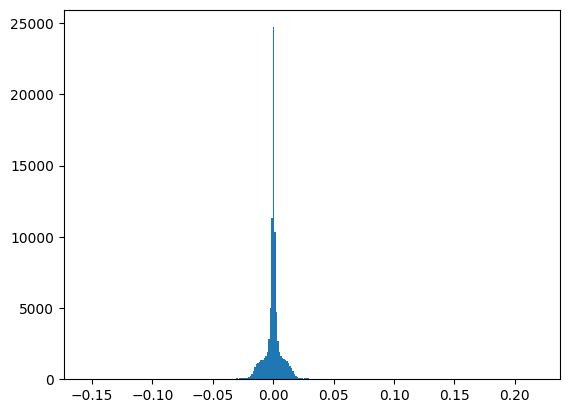

In [11]:
plt.hist(df.TARGET, bins=300);

<Axes: >

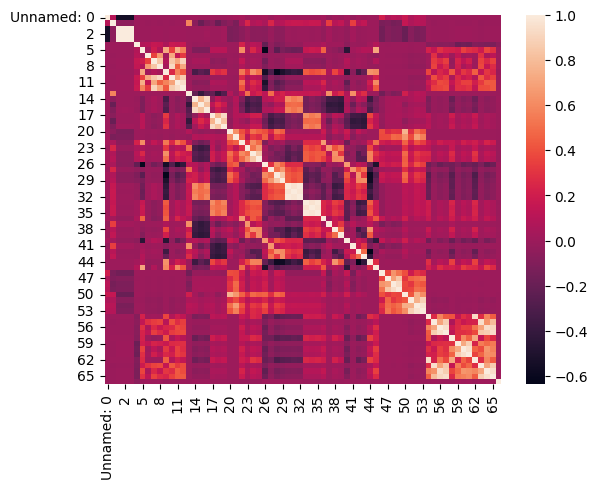

In [12]:
sns.heatmap(df.corr())

#### Linear correlation seems to be fairly concentrated in blocks of features, let's look at them more closely. Some features even look like they are perfectly correlated


In [13]:
corr_df = df.corr()
mask = corr_df >0.9
np.fill_diagonal(mask.values, False)


In [14]:
row, col = np.where(mask)


In [15]:
unique_highly_correlated_pairs = set()
for i,j in zip(row, col):
    unique_highly_correlated_pairs.add(tuple(sorted((i, j))))
unique_highly_correlated_pairs

{(np.int64(2), np.int64(3)),
 (np.int64(2), np.int64(4)),
 (np.int64(3), np.int64(4)),
 (np.int64(9), np.int64(11)),
 (np.int64(12), np.int64(13)),
 (np.int64(15), np.int64(17)),
 (np.int64(18), np.int64(20)),
 (np.int64(31), np.int64(32)),
 (np.int64(31), np.int64(33)),
 (np.int64(32), np.int64(33)),
 (np.int64(34), np.int64(35)),
 (np.int64(34), np.int64(36)),
 (np.int64(35), np.int64(36)),
 (np.int64(49), np.int64(50)),
 (np.int64(53), np.int64(54)),
 (np.int64(55), np.int64(63)),
 (np.int64(56), np.int64(64)),
 (np.int64(57), np.int64(58)),
 (np.int64(57), np.int64(65)),
 (np.int64(57), np.int64(66)),
 (np.int64(58), np.int64(66)),
 (np.int64(61), np.int64(62)),
 (np.int64(65), np.int64(66))}

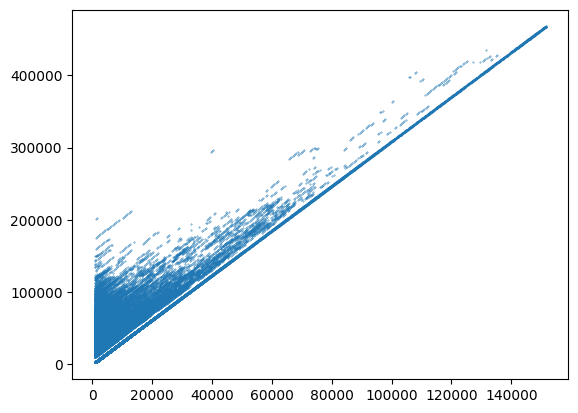

In [16]:
plt.scatter(x=df.iloc[:, 31], y=df.iloc[:, 32], s=0.1)

- Features 16, 18, 19, 21 seem to be constant through some time period and only take on certain ranges of values
- Features around 30 do not actually have a linear relationship to each other
- The other features marked with high linear correlation seem to actually be linearly correlated

#### Let's see whether the 30s features have some visible relationship when denoised


In [17]:
def bucket_plot(df, x_col, y_col, weight=None, nbins=10):
    """
        Bucketed plots of mean/ median of y over quantile bins of x.
        Args:
            df: Array of input data
            x_col: Name of feature to be binned as string
            y_col: Name of feature to be plotted as string
            weight: Name of feature to weigh samples by
            nbins: number of quantile bins to choose
    """
    
    df["quantile"]= pd.qcut(df[x_col], nbins, labels=False)
    mean_values = df.groupby("quantile")[y_col].mean()
    median_values = df.groupby("quantile")[y_col].median()
    quantile_centers = df.groupby("quantile")[x_col].mean()
    fig = plt.figure()
    plt.plot(quantile_centers, mean_values,  color="b", label="mean")
    plt.plot(quantile_centers, median_values,  color="orange", label="median")
    plt.xlabel(f"{x_col}")
    plt.ylabel(f"{y_col}")
    plt.grid(True)
    plt.legend(loc="upper right")
    return fig

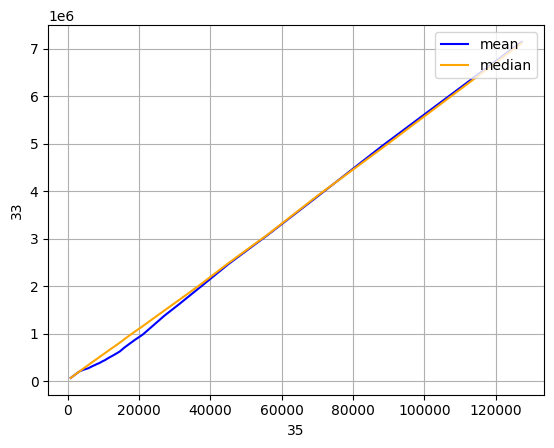

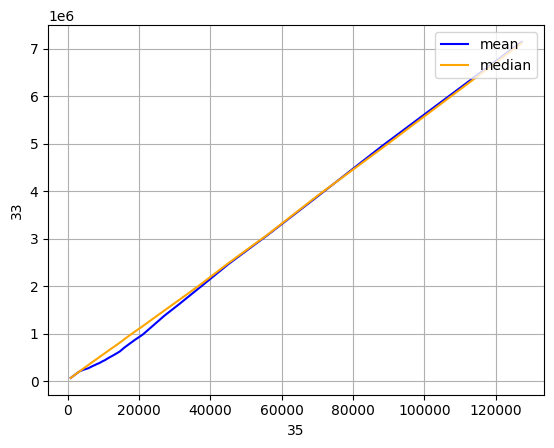

In [18]:
bucket_plot(df,  "35", "33", nbins = 50)


### Diagnosing temporal structure and potential shortcut signals

In [19]:
def calculate_autocorrelation(series, lag=1):
    return series.autocorr(lag=lag)

autocorrelations = {}
for column in df.columns:
    autocorrelations[column] = [calculate_autocorrelation(df[column], lag=i) for i in range(1, 50, 5)]


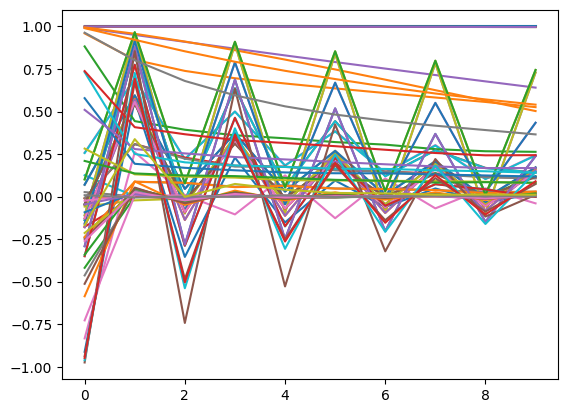

In [20]:
plt.plot(pd.DataFrame(autocorrelations));

In [21]:
features_with_autocorr = (np.arange(14,19).tolist() + np.arange(23, 25).tolist() +  np.arange(27, 30).tolist()
+ np.arange(32, 35).tolist() + np.arange(37, 39).tolist()+ np.arange(41, 44).tolist())

- Features 14-19, 23-25, 27-30, 32-35, 37-39, 41-44 seem to have some time dependent periodicity, as their autocorrelation on lags of multiples of 5 show some periodic behaviour.


### Summary: observations and implications for model behavior and failure modes

### Observations

- complete feature set, no missing data
- features have varying volatility, indicating different levels of signal to noise ratios
- features have different distributions, some are skewed with long tails, while others looked more normal
- there are features with almost perfect linear correlation, which is not (always) driven only by outliers, but are properly linearly correlated
- some features have a high linear correlation, but closer examination of scatter- and bucket plot shows highly non linear behaviour
- some features show some time dependent behaviour, their autocorrelation plots at different lags shows periodicity

### Preprocessing based on insights from EDA

- Due to different distributions of features, it makes sense to normalise them before modelling, as some models are sensitive to it
- Almost perfect linear correlation can be problematic for inference of some models, for models that are sensitive to this, ie OLS, it makes sense to use additional regularization
- Given that some features exhibit periodic behaviour at certain lags, it makes sense to augment the training data with lagged values of the original features as well as smoothed versions to capture trends in data, such as ewma

In [22]:
def create_lagged_and_smoothed_features(df, feature_indices, lags):
    """
        Creates lagged features for features of feature_indeices for the given lags
        Args:
            df: input data
            feature_indices: indices for which to create lagged versions of as new features
            lags: which lags to use for new feat
    """
    for col in feature_indices:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[f"{col}"].shift(lag)
            df[f"{col}_ewma15"] = df[f"{col}"].ewm(span=15, adjust=False).mean()
    return df


def preprocessing(df, feature_indices=features_with_autocorr, lags = np.arange(1, 50, 5)):
    """
        Preprocesses given data frame for modelling
        Args:
            df: input data
    """
    
    df = create_lagged_and_smoothed_features(df, feature_indices, lags[::2])
    df_predictors = df.drop(columns = ["TARGET"])
    df_predictors=df_predictors.fillna(0)
    return df_predictors


## Problem setup



- We formulate this problem as a regression, where tune a model to accurately predict the target PnL and then based on cross validation find the best cut-off threshold (ie minimum prediction size to choose to do a trade) to maximise the PnL
- We will build models of increasing complexity, starting first with a regularised linear model (due to feature multicollinearity) as interpretable and fast-to-train benchmark model on only the given data, then moving on to include the augmented features and finally onto non linear models
- We will compare every model setup with the linear model benchmark and the naive model that chooses to do every trade
- As linear model we choose the elastic net, as there is multicollinearity in the dataset and hence we need to regularise the OLS. Elastic Net has both l1 and l2 regularisations, so that via hyperparameter tuning we can find the best combination of these regularisations
- To model potential nonlinear relationships in the data, we choose to also try the LightGBM, a gradient bossting model, which has shown good performance on tabular data in competitions.

## Model pipeline with training visualisations



- Time series cross validation with expanding window size and grid search to find optimal parameters
- We'll choose 5 splits as the data set has medium size and 5 splits should give a good balance between ensuring model generalisation and computational effort
- First on raw data, then on augmented data
- Check in advance that the folds created this way are well balanced
- For evaluation, we will look at CV mse errors, r2, correlation to target, bucketed mse to see if the model has any biases for different target sizes as well as compare the actual PnL generated with the trades predicted from the model

### Hyperparameter tuning and evaluation setup


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

from sklearn.metrics import r2_score
from pprint import pprint
from sklearn.linear_model import LassoCV

In [25]:
df = pd.read_csv("data/Project_train.csv")
X_raw = df.drop(columns=["TARGET"])
y_raw = df["TARGET"]


% of PnL samples >0 in train fold 0, 50.55333333333333
            Avg. and median PnL(np.float64(7.645853567333336e-05), np.float64(1.52e-05)), min and max PnL  (np.float64(-0.154822771), np.float64(0.218375702))

            % of PnL samples >0 in test fold 0, 49.766666666666666
            Avg. and median PnL (np.float64(-6.562802990666573e-05), np.float64(-7.729999999999999e-06)), min and max PnL  (np.float64(-0.094748996), np.float64(0.148851631))

            
% of PnL samples >0 in train fold 1, 50.160000000000004
            Avg. and median PnL(np.float64(5.41525288333381e-06), np.float64(4.2000000000000004e-06)), min and max PnL  (np.float64(-0.154822771), np.float64(0.218375702))

            % of PnL samples >0 in test fold 1, 50.26666666666667
            Avg. and median PnL (np.float64(-2.871453557333332e-05), np.float64(4.5649999999999995e-06)), min and max PnL  (np.float64(-0.10303022), np.float64(0.107172265))

            
% of PnL samples >0 in train fold 2, 50.195555

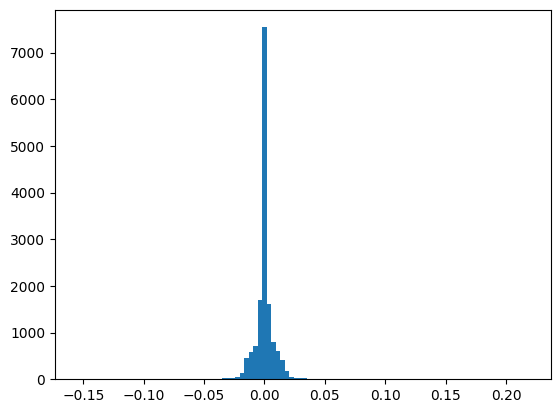

In [26]:
tscv = TimeSeriesSplit(5) 
for fold, (train_index, test_index) in enumerate(tscv.split(X_raw)):
    y_raw_train = y_raw[train_index]
    y_raw_test = y_raw[test_index]
    print(f"""% of PnL samples >0 in train fold {fold}, {(y_raw_train>0).mean()*100}
            Avg. and median PnL{y_raw_train.mean(), y_raw_train.median()}, min and max PnL  {y_raw_train.min(), y_raw_train.max()}

            % of PnL samples >0 in test fold {fold}, {(y_raw_test>0).mean()*100}
            Avg. and median PnL {y_raw_test.mean(),y_raw_test.median()}, min and max PnL  {y_raw_test.min(), y_raw_test.max()}
            
            """)
    if fold ==0:
        plt.hist(y_raw_train, bins=100)

In [27]:
def gridsearch_cv_regression(preprocessor, model, param_grid, cv, scoring, X, y):
    """
        Wrapper function to tune for hyperparameters with given parameteres and CV, and fit on entire dataset
        Args:
            preprocessor: data transformation object
            model: model object
            param_grid: grid of parameters to tune with gridsearch
            cv: chosen cross validation folds
            scoring: chosen scoring metric
            X: entire training dataset
            y: training target
      """

    pipeline = Pipeline(steps=[
            ("scaler", preprocessor),
            ("regressor", model)
        ])
    search = GridSearchCV(pipeline, cv=cv, scoring=scoring, verbose=1, param_grid=param_grid)
    search.fit(X, y)
    best_model = search.best_estimator_
    best_model_insample_pred = best_model.predict(X)

    return best_model, best_model_insample_pred
    
def evaluate_results(y_true, y_pred, thresholds):
    """
        Function that takes in true targets and predicted targets to give a summary of model performances such as MSE, r2, correlation to target and the PnL 
        if trades were done according to the rule y_pred > threshold
        Args:
            y_true: true target
            y_pred: model predicted targets
            threshold: list of thresholds for y_pred to decide which trades should be chosen 
    """
    
    print(f"MSE: {round(mean_squared_error(y_true, y_pred), 4)}\n")
    print(f"R2: {r2_score(y_true, y_pred)}\n")
    print(f"Correlation {pearsonr(y_true, y_pred)}\n")
    index_length = len(y_true)
    dummy_take_all_trades = np.ones(index_length)
    plt.figure(figsize=(10, 6))  
    pnls=[]
    for t in thresholds:
        trade_chooser = np.where(y_pred > t, 1, 0)
        pnl = trade_chooser * y_true
        plt.plot(np.arange(index_length), pnl.cumsum(), label=f"pnl_threshold_{t}")
        print(f"PnL total for threshold {t}: {pnl.cumsum().iloc[-1]}")
    
    # Dummy trades, taking every trade
    dummy_pnl = dummy_take_all_trades * y_true
    plt.plot(np.arange(index_length), dummy_pnl.cumsum(), label=f"pnl_dummy_alltrades")

    plt.title("Cumulative PNL Based on Thresholds")
    plt.xlabel("Index")
    plt.ylabel("Cumulative PNL")
    plt.legend()
    plt.grid()

    plt.show()

def bucketed_result_analysis(y_pred, y_true, nbins=20):
    """
        Function to analyse model predictions based on bucketed targets
        Args:
            y_true: true target
            y_pred: model predicted targets
            nbins: number of bins to bucket target
    """
    resid = y_true - y_pred
    df = pd.DataFrame({"residuals": abs(resid),"y_pred_binary": np.where(y_pred>0,1,0), "y_pred": y_pred,
                                    "y_true": y_true, "y_true_binary": np.where(y_true>0, 1, 0)})
    same_sign = ((df["y_pred_binary"] == 0) & (df["y_true_binary"] == 0) | 
                ((df["y_pred_binary"] > 0) & (df["y_true_binary"] > 0)))
    
    df["pred_against_binary"] = np.where(same_sign, 1,0 )
    fig1 = bucket_plot(df, "y_true", "residuals", nbins=nbins)
    fig1.show()

    bucketed_same_sign = df.groupby("quantile")["pred_against_binary"].sum().reset_index()
    fig2, ax2 = plt.subplots()  
    ax2.plot(bucketed_same_sign["quantile"], bucketed_same_sign["pred_against_binary"])
    ax2.set_xlabel("y_true")
    ax2.set_ylabel("# Same Sign Preds")
    ax2.grid(True)
    ax2.legend(["# Same Sign Preds"], loc="upper right")
    plt.show()  
    
    bucketed_corr = df.groupby("quantile").apply(lambda x: pearsonr(x["y_pred"], x["y_true"])[0]).reset_index()
    fig3, ax3 = plt.subplots() 
    ax3.plot(bucketed_corr["quantile"], bucketed_corr[0])
    ax3.set_xlabel("y_true")
    ax3.set_ylabel("Correlation")
    ax3.grid(True)
    ax3.legend(["Correlation"], loc="upper right")
    plt.show() 

    bucketed_mse = df.groupby("quantile").apply(lambda x: mean_squared_error(x["y_pred"], x["y_true"])).reset_index()
    fig3, ax3 = plt.subplots()  
    ax3.plot(bucketed_mse["quantile"], bucketed_mse[0])
    ax3.set_xlabel("y_true")
    ax3.set_ylabel("MSE")
    ax3.grid(True)
    ax3.legend(["MSE"], loc="upper right")
    plt.show() 

## Regularised linear benchmark model on raw data

In [28]:
df_test = pd.read_csv("data/Project_test.csv")
y_test = df_test["TARGET"]
X_test =df_test.drop(columns =["TARGET"])

In [29]:
tscv_raw=tscv.split(X_raw)
elasticnet_raw, elasticnet_raw_is_pred = gridsearch_cv_regression(
                                            StandardScaler(), 
                                            linear_model.ElasticNet(), 
                                            param_grid= {
                                                "regressor__l1_ratio": [9e-6, 1e-5, 2e-5],
                                                "regressor__max_iter": [500]
                                                     },
                                            cv=tscv_raw,
                                            scoring="neg_mean_squared_error",
                                            X=X_raw, y=y_raw
                                                )

Fitting 5 folds for each of 3 candidates, totalling 15 fits


MSE: 0.0001

R2: 0.003985503373597488

Correlation PearsonRResult(statistic=np.float64(0.07384579834581267), pvalue=np.float64(4.93235450740138e-109))

PnL total for threshold -0.0002006596198263482: 14.522321219800016
PnL total for threshold 0: 21.773186412500056
PnL total for threshold 0.00017054759824867765: 17.755504015999996


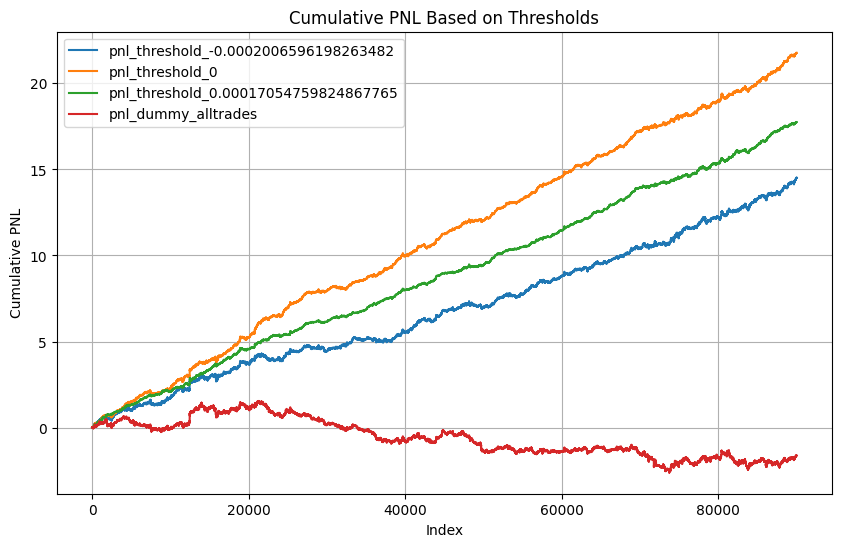

In [30]:
evaluate_results(y_raw, elasticnet_raw_is_pred, [np.quantile(elasticnet_raw_is_pred, 0.25), 0, np.quantile(elasticnet_raw_is_pred, 0.75)])

/var/folders/32/q7r1hp_17q9gccp8nwv97gqm0000gn/T/ipykernel_18597/1015837715.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


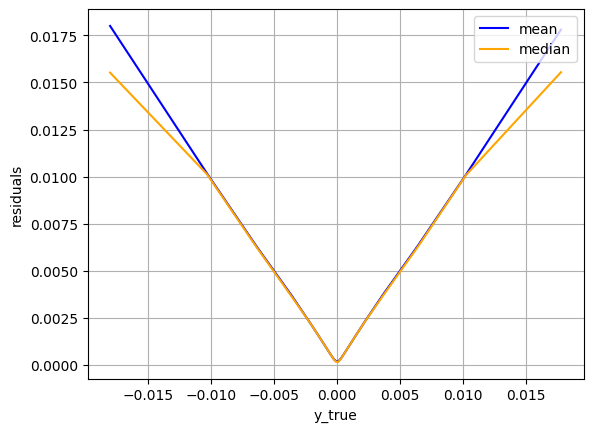

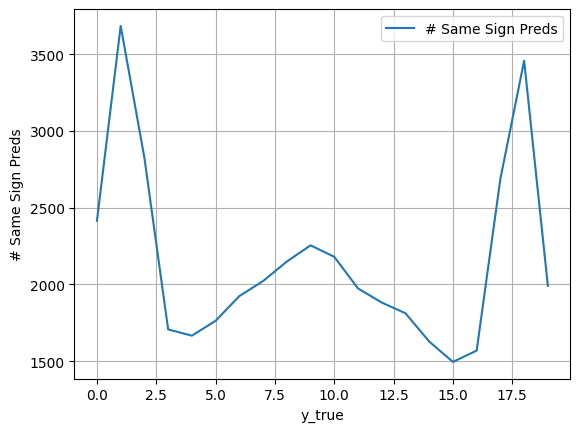

/var/folders/32/q7r1hp_17q9gccp8nwv97gqm0000gn/T/ipykernel_18597/1015837715.py:87: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucketed_corr = df.groupby("quantile").apply(lambda x: pearsonr(x["y_pred"], x["y_true"])[0]).reset_index()


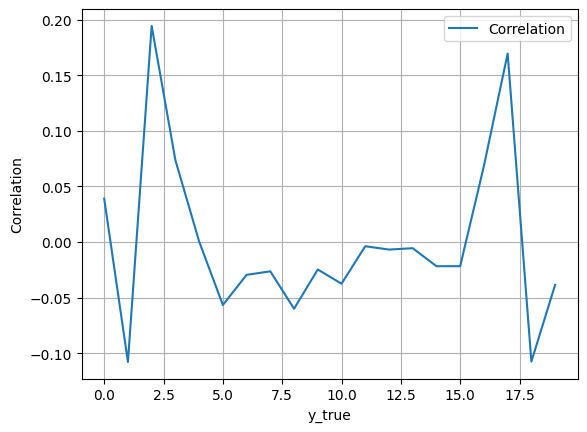

/var/folders/32/q7r1hp_17q9gccp8nwv97gqm0000gn/T/ipykernel_18597/1015837715.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucketed_mse = df.groupby("quantile").apply(lambda x: mean_squared_error(x["y_pred"], x["y_true"])).reset_index()


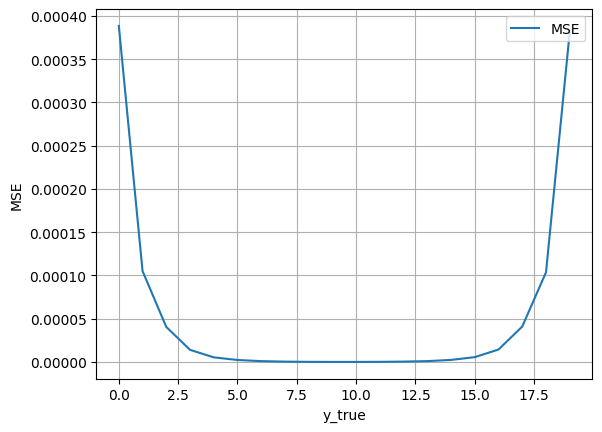

In [31]:
bucketed_result_analysis(elasticnet_raw_is_pred, y_raw)


### out of sample evaluation


In [32]:
elasticnet_raw_oos_pred= elasticnet_raw.predict(X_test)

MSE: 0.0001

R2: 0.0022504223539666635

Correlation PearsonRResult(statistic=np.float64(0.05104010137368639), pvalue=np.float64(7.537641598380866e-13))

PnL total for threshold -0.0002411299628114698: 1.894029496199997
PnL total for threshold 0: 3.699364832199987
PnL total for threshold 0.00018183156220821605: 2.8231114331999896


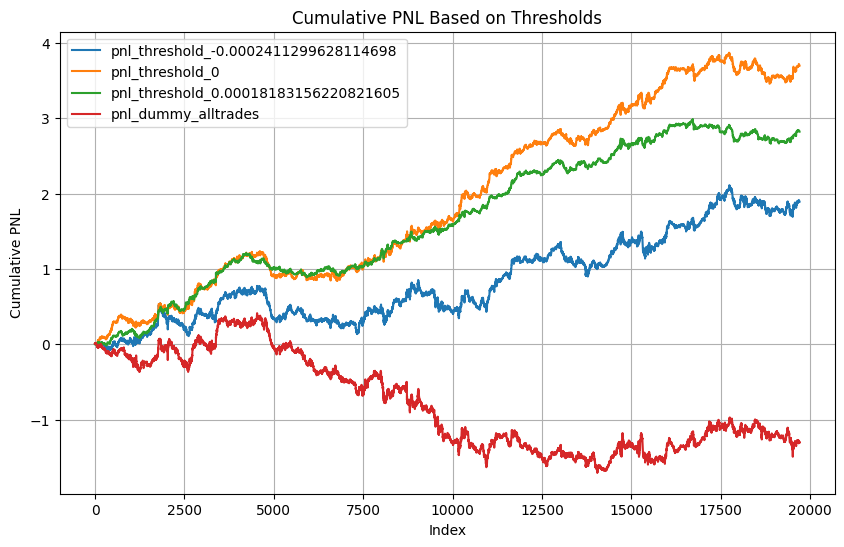

In [33]:
evaluate_results(y_test, elasticnet_raw_oos_pred, [np.quantile(elasticnet_raw_oos_pred, 0.25), 0,  np.quantile(elasticnet_raw_oos_pred, 0.75)])

### Summary benchmarking
- We build a linear benchmark with the ElasticNet, which has both l1 and l2 penalties, due to multicollineraity in the data, on raw input data that is merely scaled
- We achieve an insample r2 of 0.0039, correlation of 7.3%, corresponding to a PnL of 21.779 when choosing to trade those trades where the model outputs a positive PnL (threshold =0) and and out of sample r2 of 0.0022, correlation of 0.051, corresponding to an oos PnL of 3.72
- Bucketing the target and looking at aggregated statistics per bucket shows:
    - size of model residuals increases as size of target increases,
    - amount of predictions with corrrect sign decresses for very large target values
    - model predictions have low correlation to target for large target values

## Regularised linear models with augmented data


In [59]:
X_train = preprocessing(df)

In [60]:
X_test_aug = preprocessing(df_test)

In [61]:
tscv_aug=tscv.split(X_train)
elasticnet_aug, elasticnet_aug_is_pred = gridsearch_cv_regression(
                                            StandardScaler(), 
                                            linear_model.ElasticNet(), 
                                            param_grid= {
                                                "regressor__l1_ratio":[9e-6, 1e-5, 2e-5], 
                                                "regressor__max_iter": [500]
                                                     },
                                            cv=tscv_aug,
                                            scoring="neg_mean_squared_error",
                                            X=X_train, y=y_raw
                                                )

Fitting 5 folds for each of 3 candidates, totalling 15 fits


MSE: 0.0001

R2: 0.004100112226732455

Correlation PearsonRResult(statistic=np.float64(0.07512689523461316), pvalue=np.float64(8.611672136324379e-113))

PnL total for threshold -0.00020206649235949707: 15.012837616799992
PnL total for threshold 0: 22.341030017500113
PnL total for threshold 0.00017073810834576268: 17.615799288999987


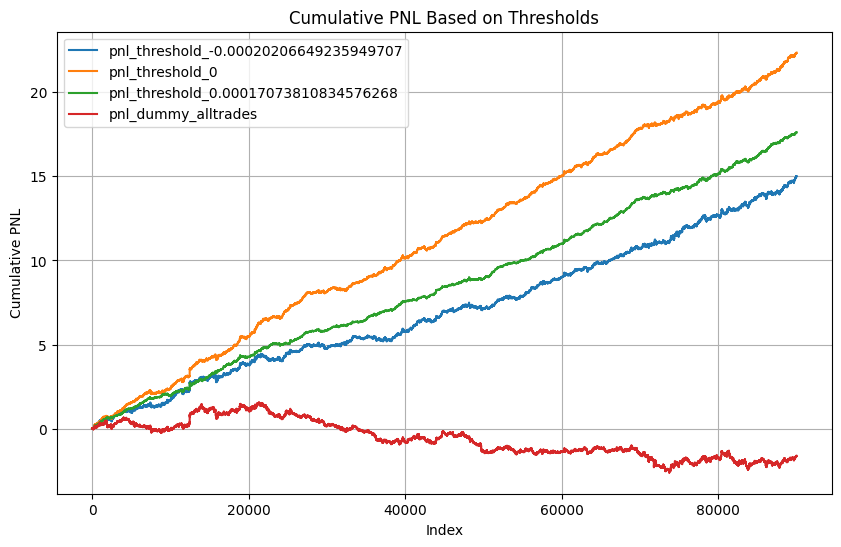

In [62]:
evaluate_results(y_raw, elasticnet_aug_is_pred, [np.quantile(elasticnet_aug_is_pred, 0.25), 0, np.quantile(elasticnet_aug_is_pred, 0.75)])

In [63]:
bucketed_result_analysis(elasticnet_is_pred, y_raw)


NameError: name 'elasticnet_is_pred' is not defined

### out of sample evaluation 

In [ ]:
elasticnet_aug_oos_pred = elasticnet_aug.predict(X_test_aug)

In [ ]:
evaluate_results(y_test, elasticnet_aug_oos_pred, [np.quantile(elasticnet_aug_oos_pred, 0.25), 0, np.quantile(elasticnet_aug_oos_pred, 0.75)])

NameError: name 'elasticnet_aug_oos_pred' is not defined

- Fitting on augmented data with our hyperparameter choices results in better in and out of sample performance for our choices of metrics
    - in sample: r2 increase of 5.1%, correlation increase of 2.8%, PnL increase of 2.6%
     - out of sample: r2 increase of 1.7%, correlation increase of 0.7%, PnL increase of 3.3%

## Nonlinear models

In [64]:
import lightgbm as lgb

In [ ]:
tscv_aug=tscv.split(X_train)
lgbm, lgbm_is_pred = gridsearch_cv_regression(
                        StandardScaler(), 
                        lgb.LGBMRegressor(objective="regression"), 
                        param_grid= {
                            #"regressor__max_depth":[6],                                            
                            "regressor__num_leaves": [20, 50],
                            "regressor__learning_rate": [0.05],
                            "regressor__min_child_samples": [400, 1000],
                            "regressor__n_estimators": [100, 150]
                                 },
                        cv=tscv_aug,
                        scoring="neg_mean_squared_error",
                        X=X_train, y=y_raw
                            )

MSE: 0.0001

R2: 0.035210107568630744

Correlation PearsonRResult(statistic=np.float64(0.22135856616172012), pvalue=np.float64(0.0))

PnL total for threshold -0.0005974722348402217: 43.70707340890042
PnL total for threshold 0: 52.564673761500046
PnL total for threshold 0.0005610521067133077: 43.49282765099996


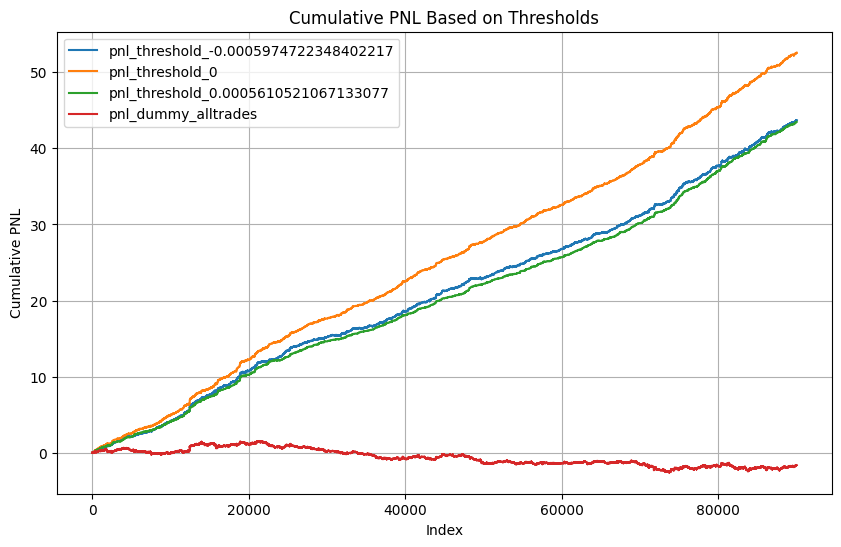

In [66]:
evaluate_results(y_raw, lgbm_is_pred,  [np.quantile(lgbm_is_pred, 0.25),0, np.quantile(lgbm_is_pred, 0.75)])

/var/folders/32/q7r1hp_17q9gccp8nwv97gqm0000gn/T/ipykernel_18597/1015837715.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


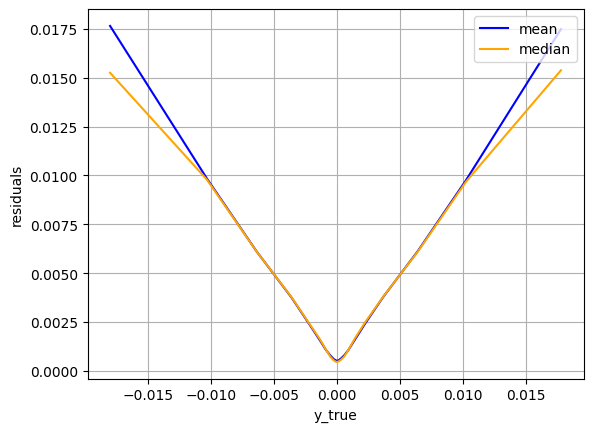

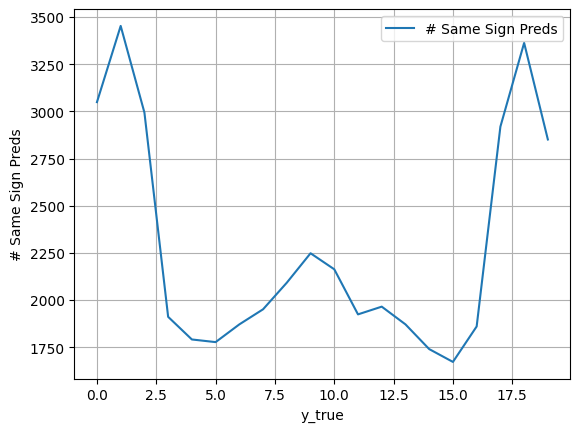

/var/folders/32/q7r1hp_17q9gccp8nwv97gqm0000gn/T/ipykernel_18597/1015837715.py:87: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucketed_corr = df.groupby("quantile").apply(lambda x: pearsonr(x["y_pred"], x["y_true"])[0]).reset_index()


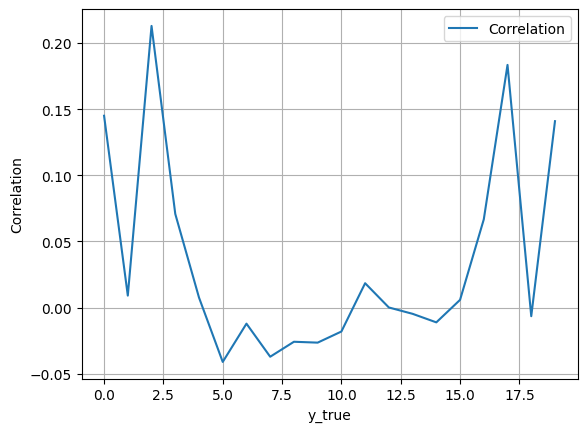

/var/folders/32/q7r1hp_17q9gccp8nwv97gqm0000gn/T/ipykernel_18597/1015837715.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucketed_mse = df.groupby("quantile").apply(lambda x: mean_squared_error(x["y_pred"], x["y_true"])).reset_index()


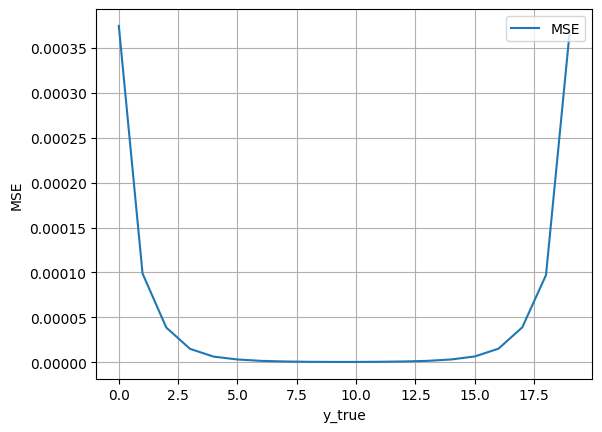

In [67]:
bucketed_result_analysis(lgbm_is_pred, y_raw)

In [68]:
# Ensure named DataFrame input for LightGBM prediction.
if isinstance(X_test_aug, pd.DataFrame):
    X_test_aug_named = X_test_aug.copy()
else:
    X_test_aug_named = pd.DataFrame(X_test_aug, columns=X_train.columns)

lgbm_oos_pred = lgbm.predict(X_test_aug_named)

/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MSE: 0.0001

R2: 0.0057800260581253315

Correlation PearsonRResult(statistic=np.float64(0.07711690993857363), pvalue=np.float64(2.1943584550280863e-27))

PnL total for threshold -0.0005564863644042981: 3.144622372200012
PnL total for threshold 0: 5.540954052199996
PnL total for threshold 0.0006064025497207634: 3.9964012301999965


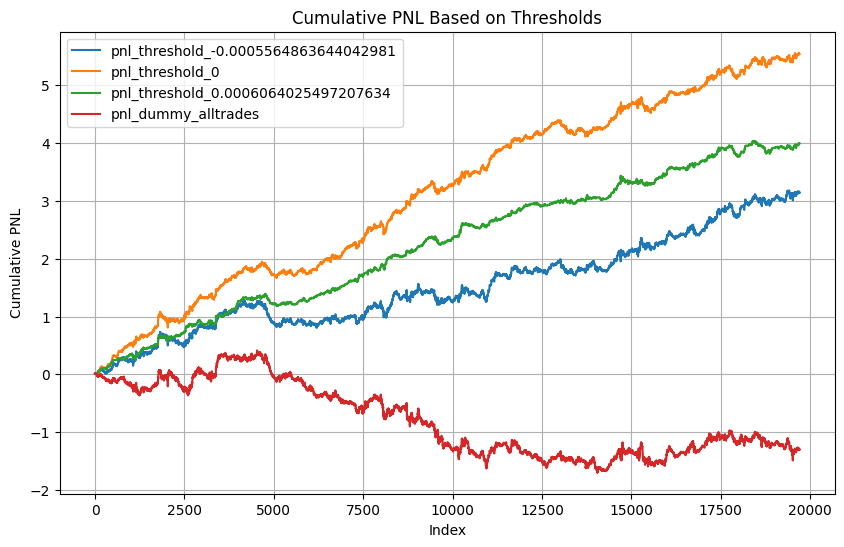

In [69]:
evaluate_results(y_test, lgbm_oos_pred, [np.quantile(lgbm_oos_pred, 0.25),0, np.quantile(lgbm_oos_pred, 0.75)])

Summary LightGBM
- LightGBM captures nonlinear relationships withint the data and overperforms the linear model by significant amounts both in and out of sample
- improvements in metrics compared to ElasticNet with augmented data: 
  - insample: r2 increase of 750%, correlation increase of 194%, PnL increase of 135%
  - out of sample: r2 increase of 40%, correlation increase of 2.6%, PnL increase of 45%

## Summary report

- Given a dataset of possible trading opprtunities and their PnLs, we try to find a model to predict which trades to do to achieve high PnL

- Based on initial exploratory data analysis, we find that:
    - some features are highly linearly correlated
    - some features have time dependencies which showed in in their autocorrelation plots as periodic high correlation at certain lags
    
- These insights from the data analysis show that during modelling, we'll want:
    - include regularisation in cases of models sensitive to multicollinearity
    - build additional features to try and capture the time dependency within the data via lagging and exponential weighting
    
- Since we know that some features are timeseries and some show periodic autocorrelation, we will want to use time series cross validation to not destroy the structure of the data when we are tuning model hyperparameters
- While modelling, it is useful to keep a benchmark model to compare all other models against to see improvements from the model or additional features. Our approach was hence ordered in the following way:
    - No model benchmark: Dummy model taking all trades
    - Benchmark: Elastic Net on raw input data
    - Elastic Net on data augmented with additional features
    - LightGBM with augmented features
    
- The ordering of the models represents an increase in complexity and modelling capabilities, going from naive constant model, over linear model to nonlinear model

- We observe better performance with every modelling step on all performance metrics tracked (r2, correlation, PnL), with a plot showing all in and out-of-sample PnLs of all models together:
    - The elastic net on raw input data outperforms nairvely taking every trade
    - Elastic Net with augmented features outperforms the elastic net on just raw input data
    - LightGBM with augmented features seems to capture non linear relationships in the data and outperforms all other considered models
    

In [70]:
def model_comparison_plots(y_true, model_preds, title, model_names = ["elasticnet_raw", "elasticnet_aug", "lgbm"]):
    plt.figure(figsize=(10, 6)) 
    index_length=len(y_true)
    
    
    dummy_take_all_trades=np.ones(index_length)
    for idx, y_pred in enumerate(model_preds):
        trade_chooser = np.where(y_pred > 0, 1, 0)
        pnl = trade_chooser * y_true
        plt.plot(np.arange(index_length), pnl.cumsum(), label=f"{model_names[idx]}")

    # Dummy trades, taking every trade
    dummy_pnl = dummy_take_all_trades * y_true
    plt.plot(np.arange(index_length), dummy_pnl.cumsum(), label=f"Dummy_model_alwaysTrades")

    plt.title(f"Comparison {title} cumulative PNL with threshold 0 across all models")
    plt.xlabel("Index")
    plt.ylabel("Cumulative PNL")
    plt.legend()
    plt.grid()

    plt.show()


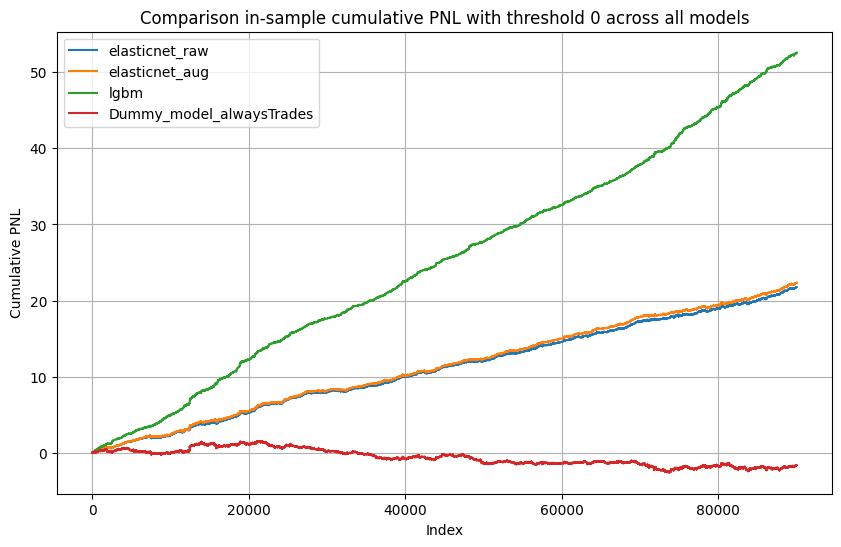

In [71]:
model_comparison_plots(y_raw, [elasticnet_raw_is_pred, elasticnet_aug_is_pred, lgbm_is_pred], "in-sample") 

In [72]:
# model_comparison_plots(y_test, [elasticnet_raw_oos_pred, elasticnet_aug_oos_pred, lgbm_oos_pred], "out-of-sample") 

### Limitations of proxy objectives and alternative formulations

The target used here is an imperfect proxy for the underlying objective.
As a result, optimizing performance on this target can encourage models
to exploit structure that improves the metric without improving real
downstream outcomes.

Conceptually, we could consider objectives of the form:

Expected_Outcome = E[p(x) · y]

where p(x) is a model output and y is an observed outcome. While appealing,
this formulation highlights how easily objectives become fragile when the
observed signal is noisy, delayed, non-stationary, or only partially aligned
with the true goal.

Rather than proposing a single "correct" loss, this analysis emphasizes the
importance of diagnosing where proxy objectives break down and using
complementary evaluations (e.g. bucketed errors, horizon-dependent metrics)
to assess robustness and guide model selection and deployment.

# Final summary


A key takeaway from this analysis is that strong aggregate statistics
(e.g. linear correlation) can hide systematic and misleading structure,
including non-linear relationships, redundancy, and temporal periodicity.

Understanding these patterns was more informative than further model tuning
and shaped how I would evaluate model reliability in a real system.

## Interpretability Extension: Causal Ablations

This section extends the original assignment with targeted interventions to test causal importance.

Added analyses:
- Leave-one-feature-out (LOFO) ablation on top LightGBM features.
- Grouped feature ablations (trend/momentum, volatility, volume, lag-smoothed).

These are run on the out-of-sample test set to check whether key signals are actually necessary for model behavior.

In [83]:
# Utility metrics for ablation experiments.
def as_feature_frame(X_like, feature_names):
    """Ensure sklearn/lightgbm always receives a named DataFrame."""
    if isinstance(X_like, pd.DataFrame):
        return X_like.loc[:, feature_names]
    return pd.DataFrame(X_like, columns=feature_names)


def eval_pred_metrics(y_true, y_pred, threshold=0.0):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mse = mean_squared_error(y_true, y_pred)
    corr = pearsonr(y_true, y_pred)[0]

    chooser = (y_pred > threshold).astype(int)
    pnl_total = float((chooser * y_true).sum())
    trade_rate = float(chooser.mean())

    return {
        'mse': float(mse),
        'corr': float(corr),
        'pnl': pnl_total,
        'trade_rate': trade_rate,
    }


def print_metric_delta(name, base, alt):
    print(f"{name:30s} | corr {alt['corr']:.4f} ({alt['corr']-base['corr']:+.4f}) | "
          f"mse {alt['mse']:.6f} ({alt['mse']-base['mse']:+.6f}) | "
          f"pnl {alt['pnl']:.2f} ({alt['pnl']-base['pnl']:+.2f})")


feature_names = list(X_train.columns)
X_test_named = pd.DataFrame(X_test_aug, columns=X_train.columns)
base_pred = lgbm.predict(X_test_named)
base_metrics = eval_pred_metrics(y_test, base_pred)
print('Baseline (LightGBM, out-of-sample):')
print(base_metrics)

Baseline (LightGBM, out-of-sample):
{'mse': 8.088526784085534e-05, 'corr': 0.07711690993857363, 'pnl': 5.5409540522, 'trade_rate': 0.4999746283046633}


/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [85]:
# LOFO ablation over top features by model importance.
reg = lgbm.named_steps['regressor']
feature_importance = pd.Series(reg.feature_importances_, index=feature_names).sort_values(ascending=False)
top_features = feature_importance.head(15).index.tolist()

X_train_named = as_feature_frame(X_train, feature_names)
fill_values = X_train_named.median(numeric_only=True)

lofo_rows = []
for feat in top_features:
    X_ab = X_test_named.copy()
    X_ab[feat] = fill_values.get(feat, 0.0)

    pred_ab = lgbm.predict(X_ab)
    m = eval_pred_metrics(y_test, pred_ab)
    lofo_rows.append({
        'feature': feat,
        'delta_corr': m['corr'] - base_metrics['corr'],
        'delta_mse': m['mse'] - base_metrics['mse'],
        'delta_pnl': m['pnl'] - base_metrics['pnl'],
    })

lofo_df = pd.DataFrame(lofo_rows).sort_values('delta_corr')
print('Top LOFO drops (most negative delta_corr first):')
print(lofo_df.head(12).to_string(index=False))

/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserW

Top LOFO drops (most negative delta_corr first):
feature  delta_corr     delta_mse  delta_pnl
      4   -0.014957  1.943785e-07  -1.159498
      6   -0.009140  1.133203e-07  -0.495446
     12   -0.008535  9.374678e-08  -1.151925
     10   -0.007322  7.731729e-08  -0.617609
     45   -0.001981  2.440672e-08  -0.313189
      0   -0.001191  1.304110e-08   0.018990
     11   -0.001160  1.459552e-08  -0.065461
      8   -0.000803  1.044476e-08  -0.167461
     50   -0.000570  7.446719e-09  -0.160427
     21   -0.000556  2.395094e-09  -0.096644
     61    0.000196  2.659288e-09  -0.350496
     52    0.000421 -4.247285e-09  -0.104163


/Users/rui/Documents/Rui/Python/Codes/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Interpretation notes

- Features/groups with large negative `delta_corr` or `delta_pnl` are causally important to the model's out-of-sample behavior.
- This gives a stronger interpretability claim than feature importance alone, because it is intervention-based.